# SymPyで自動コード生成

SymPyは数式をさまざまな形式で出力することができます。LaTeXやMathMLなどの表示用の形式に加えて、式をPython、C、Fortranのコードに変換し、シンボリック式を数値演算関数に変換することも可能です。

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import helper.matplotlib
from sympy import *
import sympy

## `lambdify`で式から関数に変換

`lambdify()`は式を数値演算関数に変換します。例えば、以下では`solve()`を使用して二次方程式の2つのシンボリック解を取得します。

In [2]:
a, b, c, x = symbols("a, b, c, x", real=True)
quadratic_roots = solve(a * x**2 + b * x + c, x)
quadratic_roots

[(-b - sqrt(-4*a*c + b**2))/(2*a), (-b + sqrt(-4*a*c + b**2))/(2*a)]

次に、`lambdify()` を呼び出して数式を数値演算関数に変換し、最後にその関数を実行して方程式の数値解を求めます。`lambdify()` の第一引数は、生成される関数の引数に対応するシンボルのリストで、第二引数はその関数の返り値です。また、リストやタプルを用いることで、複数の数式の計算結果を同時に返すこともできます。

In [3]:
func_quadratic_roots_default = lambdify([a, b, c], quadratic_roots)
func_quadratic_roots_default(2, -3, 1)

[np.float64(0.5), np.float64(1.0)]

作成された関数の `modules` 引数を指定することで、式内で使用される数学関数の元のモジュールを設定できます。デフォルトでは、次のルールに従って数学関数が検索されます。  

- SciPy がインストールされている場合：`["scipy", "numpy"]`  
- NumPy のみがインストールされている場合：`["numpy"]`  
- どちらもインストールされていない場合：`["math", "mpmath", "sympy"]`  

つまり、利用可能であれば SymPy の関数は可能な限り `scipy` や `numpy` の関数に置き換えられ、そうでない場合は Python の標準ライブラリ `math` や `mpmath` の関数が使用されます。  

本書の Python 環境には NumPy がインストールされているため、`sqrt` 関数は `numpy.sqrt()` に置き換えられ、配列を引数として渡すことも可能になります。次の例では、3 つの二次方程式を解きます。  

In [4]:
func_quadratic_roots_default(np.array([2, 1, 0.5]), -3, 1)

[array([0.5       , 0.38196601, 0.35424869]),
 array([1.        , 2.61803399, 5.64575131])]

次は、`func_quadratic_roots_default` のソースコードと、その関数内で使用されている `sqrt` の参照先を確認します。これにより、`lambdify()` によって生成された関数の内部構造を確認し、どの関数が使用されているのかを調べることができます。

In [5]:
import inspect

print(inspect.getsource(func_quadratic_roots_default))  # 関数のソースコードを表示
print(
    func_quadratic_roots_default.__globals__["sqrt"] is np.sqrt
)  # 関数内で使用される sqrt の参照を取得

def _lambdifygenerated(a, b, c):
    return [(1/2)*(-b - sqrt(-4*a*c + b**2))/a, (1/2)*(-b + sqrt(-4*a*c + b**2))/a]

True


以下の例では、`cmath` モジュールの `sqrt()` 関数を使用するように変更し、複素数の結果を得られるようにしています。  

In [6]:
import cmath

func_quadratic_roots_cmath = lambdify((a, b, c), quadratic_roots, modules=cmath)
func_quadratic_roots_cmath(2, 2, 1)

[(-0.5-0.5j), (-0.5+0.5j)]

ソースコードと `sqrt` 関数を確認します。ソースコード自体は `func_quadratic_roots_default()` と同じですが、参照されている `sqrt` 関数が `cmath` モジュールのものであることがわかります。  

In [7]:
print(inspect.getsource(func_quadratic_roots_cmath))
print(func_quadratic_roots_cmath.__globals__["sqrt"].__module__)

def _lambdifygenerated(a, b, c):
    return [(1/2)*(-b - sqrt(-4*a*c + b**2))/a, (1/2)*(-b + sqrt(-4*a*c + b**2))/a]

cmath


上で生成されたソースコードをよく見ると、同じ計算が重複して実行されているため、計算速度が遅くなっています。`lambdify()` の `cse` 引数を `True` に設定すると、重複した式を検出してローカル変数に代入し、計算回数を減らすことができます。この場合、生成される関数は次のようになります。  

In [8]:
func_quadratic_roots_cse = lambdify((a, b, c), quadratic_roots, cse=True)
print(inspect.getsource(func_quadratic_roots_cse))

def _lambdifygenerated(a, b, c):
    x0 = sqrt(-4*a*c + b**2)
    x1 = (1/2)/a
    return [x1*(-b - x0), x1*(-b + x0)]



このように、`sqrt(-4*a*c + b**2)` の計算結果が変数 `x0` に、`(1/2)/a` の計算結果が変数 `x1` に格納されることで、同じ計算の重複がなくなり、計算効率が向上します。

辞書で自分で定義した関数群を `modules` 引数に渡すことで、呼び出す関数をさらにカスタマイズすることができます。次のコードでは、`my_sqrt` 関数が `modules` 引数に渡され、`sqrt` 関数として使用されます。生成された関数を呼び出すと、`my_sqrt` が計算に使われ、その際にメッセージが表示されます。この方法で、標準の数学関数を自分のカスタム関数に置き換えることができ、さらに柔軟な計算が可能になります。

今回の `modules` 引数はリスト形式で、リスト内には使用するモジュールや関数を指定しています。このリスト内では、順番に指定されたモジュールが優先され、最初に見つかった関数が使用されます。

In [9]:
def my_sqrt(x):
    print(f"call my_sqrt with {x}")
    return x**0.5


func_quadratic_roots_myfunc = lambdify(
    (a, b, c), quadratic_roots, modules=[{"sqrt": my_sqrt}, "numpy"], cse=True
)
func_quadratic_roots_myfunc(2, -3, 1)

call my_sqrt with 1


[0.5, 1.0]

In [10]:
func_quadratic_roots_myfunc.__globals__["sqrt"]

<function __main__.my_sqrt(x)>

`lambdify()`でコードを生成する際、一部の関数は内部で認識され、特別な処理が行われることがあります。この場合、`modules` 引数で関数をカスタマイズできなくなることがあります。その際、数式の `replace()` メソッドを使用して関数を置き換え、正しいコードを生成することができます。以下の例では、式 $\min (2 \sin(t), 1)$ が生成するコードが配列のベクトル演算をサポートするように、`Min()` を `numpy.amin()` に置き換えています。`inspect` モジュールが出力する自動生成コードから、SymPy の最小値関数 `Min()` が NumPy の `amin()` に変換されていることがわかります。しかし、パラメータ `t` が配列の場合、例外が発生します。

In [11]:
t = symbols("t", real=True)
expr = Min(2 * sin(t), 1)

f1 = lambdify([t], expr, modules="numpy")
print(inspect.getsource(f1))

x = np.linspace(0, 2 * np.pi, 10)
try:
    f1(x)
except ValueError as ex:
    print(ex)

def _lambdifygenerated(t):
    return amin(numpy.asarray([1,2*sin(t)]), axis=0)

setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.


NumPy の `minimum()` は最小値を計算する ufunc 関数であり、これを使用することで配列のベクトル演算を行うことができます。`Min()` を `minimum()` に変換するためには、まず SymPy の関数 `minimum` をカスタム定義し、`replace()` を使用して式内の `Min` をこの関数に置き換えます。以下のコードでは、`minimum` 関数を定義し、`replace()` を使って `Min` を `minimum` に置き換えた後、`lambdify()` を使用して生成した関数を実行しています。

In [12]:
minimum = Function("minimum")
f2 = lambdify([t], expr.replace(Min, minimum), modules="numpy")
print(inspect.getsource(f2))
print(f2(x))

def _lambdifygenerated(t):
    return minimum(1, 2*sin(t))

[ 0.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  6.84040287e-01 -6.84040287e-01 -1.73205081e+00 -1.96961551e+00
 -1.28557522e+00 -4.89858720e-16]


カスタム関数と計算関数の名前が異なる場合、`modules` パラメータ内の辞書オブジェクトを使用して、カスタム関数と計算関数の対応関係を指定することができます。生成されたコードでは `myfunc()` が呼び出されますが、`f2()` の実行環境では `myfunc` は `np.minimum()` を表します。以下のコードでは、この方法を利用して `Min` 関数を `myfunc` に置き換え、実行時に `myfunc` が `np.minimum()` として動作することを示しています。

In [13]:
myfunc = Function("myfunc")
f2 = lambdify([t], expr.replace(Min, myfunc), modules=[{"myfunc": np.minimum}, "numpy"])
print(inspect.getsource(f2))
print(f2.__globals__["myfunc"])

def _lambdifygenerated(t):
    return myfunc(1, 2*sin(t))

<ufunc 'minimum'>


## Splineのコード生成

スプラインは、滑らかな曲線を複数の多項式で表現する方法です。主に、データの補間や近似に使用されます。スプライン隣接する点を滑らかに結ぶ多項式を使い、曲線がデータ点を越えたり、急激に変化しないように調整します。以下のコードは、スプライン補間を使用してデータの滑らかな近似を行うものです。 `UnivariateSpline`は、与えられたデータ点（`x_arr` と `y_arr`）を使ってスプライン補間を行います。引数`s=1`はスムージングパラメータで、データのフィット具合を調整します。

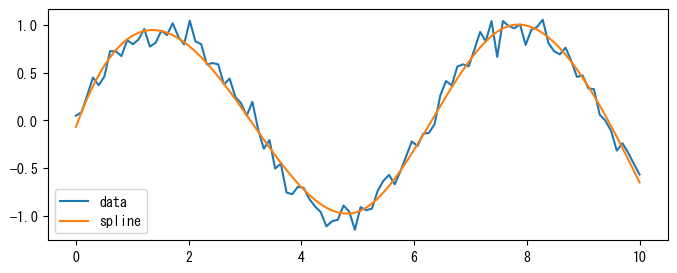

In [14]:
from scipy import interpolate

np.random.seed(42)
x_arr = np.linspace(0, 10, 100)
y_arr = np.sin(x_arr) + np.random.normal(scale=0.1, size=x_arr.shape[0])
spline = interpolate.UnivariateSpline(x_arr, y_arr, s=1)
plt.figure(figsize=(8, 3))
plt.plot(x_arr, y_arr, label="data")
plt.plot(x_arr, spline(x_arr), label="spline")
plt.legend();

`UnivariateSpline`クラスの内部の属性`_eval_args`は、スプラインを評価するために必要な情報を保持します。この属性にはスプライン補間の詳細なパラメータが格納されており、`knots`, `coeffs`, `n`が含まれています。

- `knots`は、スプラインを補間するために使用されるノット（結び目）の位置を示します。これらはデータ点の位置に基づいて決定されます。スプラインはこれらのノットを通過するように構築され、ノットはスプラインの区間を定義します。

- `coeffs`は、各区間でのスプラインの多項式係数を示します。スプラインは多項式で構成されており、各区間ごとに異なる多項式が使用されます。これらの係数は、スプライン補間を行う際に計算されたものです。

- `n`は、補間に使用するノットの数を示します。

In [15]:
knots, coeffs, n = spline._eval_args
print(knots)
print(coeffs)
print(n)

[ 0.          0.          0.          0.          2.52525253  5.05050505
  7.57575758 10.         10.         10.         10.        ]
[-0.06742978  1.30989715  0.85005837 -2.17680281  2.11149148  0.3339333
 -0.65072061  0.          0.          0.          0.        ]
3


SymPyでは`bspline_basis_set()`でBスプラインの基底関数を式に計算できます。次のコードは上で得られた`knots`でスプラインの基底関数の式を計算し、その式をグラフに描画します。

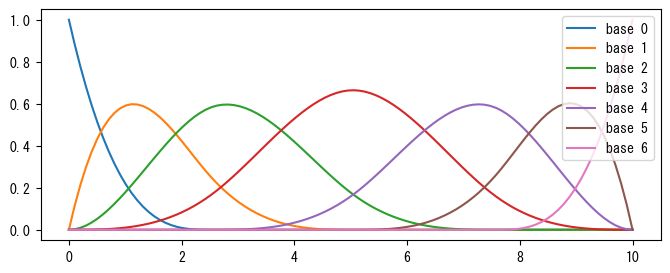

In [16]:
x = Symbol("x")
base_curves = bspline_basis_set(n, knots, x)

plt.figure(figsize=(8, 3))
for i, curve in enumerate(base_curves):
    plt.plot(x_arr, lambdify([x], curve)(x_arr), label=f"base {i}")
plt.legend();

各基底関数は`Piecewise()`で表される分段関数です。

In [17]:
base_curves[0]

Piecewise((-0.062099136*x**3 + 0.470448*x**2 - 1.188*x + 1.0, (x <= 2.52525252525253) & (x >= 0)), (0, True))

In [18]:
base_curves[1]

Piecewise((0.108673488*x**3 - 0.705672*x**2 + 1.188*x, (x <= 2.52525252525253) & (x >= 0)), (-0.015524784*x**3 + 0.235224*x**2 - 1.188*x + 2.0, (x >= 2.52525252525253) & (x <= 5.05050505050505)), (0, True))

各基底関数と`coeffs`中の対応する係数を掛け合わせ、その総和を計算すれば、結果はスプライン関数になります。次のコードでは、`spline_expr`で計算した結果と`spline`で計算した結果が一致することが分かります。

In [19]:
spline_expr = sum([v * curve for v, curve in zip(coeffs, base_curves)])
spline_func = lambdify([x], spline_expr, cse=True)
np.allclose(spline(x_arr), spline_func(x_arr))

True

生成したコードを見ると、NumPyのufunc関数が多く使用されています。

In [20]:
print(inspect.getsource(spline_func))

def _lambdifygenerated(x):
    x0 = x**2
    x1 = x**3
    x2 = logical_and.reduce((greater_equal(x, 7.57575757575758),less_equal(x, 10.0)))
    x3 = 1.188*x
    x4 = -0.470448*x0
    x5 = logical_and.reduce((less_equal(x, 2.52525252525253),greater_equal(x, 0)))
    x6 = -0.235224*x0
    x7 = logical_and.reduce((greater_equal(x, 2.52525252525253),less_equal(x, 5.05050505050505)))
    x8 = logical_and.reduce((greater_equal(x, 5.05050505050505),less_equal(x, 7.57575757575758)))
    x9 = 0.010349856*x1
    return -0.650720613486879*select([x2,True], [12.0849609375*x - 1.59521484375*x0 + 0.070189453125*x1 - 30.517578125,0], default=nan) - 0.0674297796339641*select([x5,True], [-0.062099136*x1 - x3 - x4 + 1.0,0], default=nan) + 1.30989714910869*select([x5,x7,True], [-0.705672*x0 + 0.108673488*x1 + x3,-0.015524784*x1 - x3 - x6 + 2.0,0], default=nan) + 0.33393329597181*select([x8,x2,True], [1.23698458975427*x - 0.244922948771345*x0 + 0.0161649146189088*x1 - 2.08246563931695,-22.4495388477457*x

`modules`を`"math"`に設定すれば、生成されたコードが`if else`文で構成されていることが分かります。

In [21]:
spline_func_scalar = lambdify([x], spline_expr, modules="math", cse=True)
print(inspect.getsource(spline_func_scalar))

def _lambdifygenerated(x):
    x0 = x**2
    x1 = x**3
    x2 = (x >= 7.57575757575758) and (x <= 10.0)
    x3 = 1.188*x
    x4 = -0.470448*x0
    x5 = (x >= 0) and (x <= 2.52525252525253)
    x6 = -0.235224*x0
    x7 = (x >= 2.52525252525253) and (x <= 5.05050505050505)
    x8 = (x >= 5.05050505050505) and (x <= 7.57575757575758)
    x9 = 0.010349856*x1
    return -0.650720613486879*((12.0849609375*x - 1.59521484375*x0 + 0.070189453125*x1 - 30.517578125) if x2 else (0)) - 0.0674297796339641*((-0.062099136*x1 - x3 - x4 + 1.0) if x5 else (0)) + 1.30989714910869*((-0.705672*x0 + 0.108673488*x1 + x3) if x5 else (-0.015524784*x1 - x3 - x6 + 2.0) if x7 else (0)) + 0.33393329597181*((1.23698458975427*x - 0.244922948771345*x0 + 0.0161649146189088*x1 - 2.08246563931695) if x8 else (-22.4495388477457*x + 2.88169814497865*x0 - 0.121406413506091*x1 + 57.731987485683) if x2 else (0)) + 0.850058366700105*((-0.056924208*x1 - x6) if x5 else (1.782*x + 0.036224496*x1 + x4 - 1.5) if x7 else (-1.782*x +

[numbaの`vectorize`](numba-vectorize)を使用して、スカラーを計算する関数をufunc関数にコンパイルできます。次に、コンパイルした`spline_func_scalar_jit`関数の出力が`spline`と一致することが分かります。

In [22]:
from numba import vectorize, float64

spline_func_scalar_jit = vectorize([float64(float64)])(spline_func_scalar)
np.allclose(spline(x_arr), spline_func_scalar_jit(x_arr))

True

両者の速度を比較すると、`spline_func_scalar_jit()`の方が3倍速いことが分かります。

In [23]:
%timeit spline(x_arr)
%timeit spline_func_scalar_jit(x_arr)

19.7 μs ± 1.2 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
4.96 μs ± 112 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## `autowrap()`で式のコンパイル

`lambdify()`は式をPythonの関数に変換します。しかし、大量の計算が必要な式の場合、Python関数の計算能力には限界があります。計算速度を向上させたい場合は、`autowrap()`を使用して式をC言語またはFortran言語のコードに変換し、Pythonから呼び出せる拡張モジュールとしてコンパイルできます。`backend`パラメータを使用して、拡張モジュールのコンパイル方法を指定できます：

* `'f2py'`：デフォルト値で、`f2py`を使用してFortranプログラムを拡張モジュールにラップします。
* `'cython'`：Cythonを使用してCプログラムを拡張モジュールにラップします。

次は、`mingw32`を使うため、ビルド用のフォルダを作成し、その中に`setup.cfg`をコピーします。

In [24]:
from pathlib import Path
import shutil

tmpdir = Path("./autowrap")
tmpdir.mkdir(parents=True, exist_ok=True)
shutil.copy("./setup.cfg", tmpdir);

以下では、まず2つの解を含む式を保存するリストを、行列を表す`Matrix`オブジェクト`matrix_roots`に変換します。次に、`autowrap()`を呼び出して`matrix_roots`を関数に変換します。この関数は実数解のみを返すことに注意してください。

`autowrap()`が正常に動作するためには、`tempdir`パラメータを使用して一時ファイルを保存するパスを設定する必要があります。このパスには、出力されたソースコードとコンパイルされた拡張モジュールが保存されます。`flags`パラメータを使用して追加のコンパイルコマンドを指定できます。ここでは、`-I`パラメータを使用してNumPyのC言語ヘッダーファイルのパスをコンパイラのヘッダーファイル検索パスに追加します。

In [25]:
from sympy.utilities.autowrap import autowrap

matrix_roots = Matrix(quadratic_roots)
quadratic_roots_cython = autowrap(
    matrix_roots,
    args=[a, b, c],
    tempdir=tmpdir,
    backend="cython",
    flags=["-I" + np.get_include()],
)
quadratic_roots_cython(2, -3, 1)

array([[0.5],
       [1. ]])

`spline_expr`もコンパイルしてみます。今回は`-Ofast`をコンパイラに渡して最適化したバイナリを出力できます。

In [26]:
spline_cython = autowrap(
    spline_expr,
    args=[x],
    tempdir=tmpdir,
    backend="cython",
    flags=["-I" + np.get_include()],
    extra_compile_args=["-Ofast"],
)

In [27]:
np.allclose([spline_cython(v) for v in x_arr], spline(x_arr))

True

上の`spline_cython()`は一度に一つの値しか計算できません。Pythonのループでこの関数を繰り返し呼び出すのは非効率的です。この場合、`ufuncify()`を使用して式をNumPyのufunc関数にラップすることができます。次に、`ufuncify()`を使って`spline_expr`をufunc関数としてビルドします。

In [28]:
from sympy.utilities.autowrap import ufuncify

spline_cython_ufunc = ufuncify(
    [x],
    spline_expr,
    backend="cython",
    tempdir=tmpdir,
    flags=["-I" + np.get_include()],
    extra_compile_args=["-Ofast"],
)

まず、計算結果の正確性をチェックします。

In [29]:
np.allclose(spline_cython_ufunc(x_arr), spline(x_arr))

True

次に、計算効率を評価します。これにより、Numbaのバージョンよりも速いことが分かります。

In [30]:
%timeit spline_cython_ufunc(x_arr)

1.65 μs ± 33.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


## codegenでソースコード作成

`codegen()`は式をソースコードに変換します。最初の引数は2つの要素のタプルまたは複数の2要素タプルのリストで、各タプルは関数名と式で構成されます。`language`パラメータは出力するソースコードの言語を指定し、`prefix`パラメータは出力するソースコードのファイル名を指定します。これは2つのタプルを返します。それぞれソースコードファイルとヘッダーファイルのファイル名とその内容です。シンボリック式が行列を表す`Matrix`オブジェクトの場合、出力コードでは配列を使用して各要素を保存します。

In [31]:
from sympy.utilities.codegen import codegen

(c_name, c_code), (h_name, c_header) = codegen(
    [
        ("root0", quadratic_roots[0]),
        ("root1", quadratic_roots[1]),
        ("roots", matrix_roots),
    ],
    language="C",
    prefix="quadratic_roots",
    header=False,
)
print(h_name)
print("-" * 40)
print(c_header)
print()
print(c_name)
print("-" * 40)
print(c_code)

quadratic_roots.h
----------------------------------------

#ifndef PROJECT__QUADRATIC_ROOTS__H
#define PROJECT__QUADRATIC_ROOTS__H

double root0(double a, double b, double c);
double root1(double a, double b, double c);
void roots(double a, double b, double c, double *out_8635771425010683157);

#endif



quadratic_roots.c
----------------------------------------
#include "quadratic_roots.h"
#include <math.h>

double root0(double a, double b, double c) {

   double root0_result;
   root0_result = (1.0/2.0)*(-b - sqrt(-4*a*c + pow(b, 2)))/a;
   return root0_result;

}

double root1(double a, double b, double c) {

   double root1_result;
   root1_result = (1.0/2.0)*(-b + sqrt(-4*a*c + pow(b, 2)))/a;
   return root1_result;

}

void roots(double a, double b, double c, double *out_8635771425010683157) {

   out_8635771425010683157[0] = (1.0/2.0)*(-b - sqrt(-4*a*c + pow(b, 2)))/a;
   out_8635771425010683157[1] = (1.0/2.0)*(-b + sqrt(-4*a*c + pow(b, 2)))/a;

}



さらに、`ccode()`と`fcode()`を使用してシンボリック式をC言語とFortran言語の式として出力することもできます：

In [32]:
print(ccode(matrix_roots, assign_to="y"))

y[0] = (1.0/2.0)*(-b - sqrt(-4*a*c + pow(b, 2)))/a;
y[1] = (1.0/2.0)*(-b + sqrt(-4*a*c + pow(b, 2)))/a;


`cse`機能を使いたい場合は、直接`CCodeGen`クラスを使用します。インスタンスを作成する際に、`cse`引数を`True`に設定すると、cse機能を使用してコードが生成されます。

In [33]:
from sympy.utilities.codegen import CCodeGen

gen = CCodeGen("spline", cse=True)
r1 = gen.routine("spline_func", spline_expr, [x])
for filename, code in gen.write([r1], "spline"):
    print(filename)
    print(code)

spline.c
/******************************************************************************
 *                      Code generated with SymPy 1.13.3                      *
 *                                                                            *
 *              See http://www.sympy.org/ for more information.               *
 *                                                                            *
 *                       This file is part of 'spline'                        *
 ******************************************************************************/
#include "spline.h"
#include <math.h>

double spline_func(double x) {
   const double x0 = pow(x, 2);
   const double x1 = pow(x, 3);
   const double x2 = x >= 7.5757575757575752 && x <= 10.0;
   const double x3 = 1.1880000000000002*x;
   const double x4 = -0.47044800000000003*x0;
   const double x5 = x >= 0 && x <= 2.5252525252525251;
   const double x6 = -0.23522400000000002*x0;
   const double x7 = x >= 2.5252525252525251 &